# Transfer learning and Fine tuning

In [1]:
pip install timer torchmetrics mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.transforms import v2 as T

from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm
import timer
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import a dataset

In [4]:
weights = torchvision.models.ResNet18_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ResNet18_Weights.IMAGENET1K_V1

In [5]:
# Note: resnet is trained for images in a specific range (NOT [-1,1]).
#       That changes the mean/std normalization values in the transform.

# transformations
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # further normalization
                       ])

# Note: The auto_transforms are the correct transformation to use with the model.
#       They will also resize the inputs to the shape with which the Resnet model was trained on
#       At home try to use the transform transforms defined above.
#       See what is the diference if you don't resize the images.
auto_transforms = weights.transforms()
auto_transforms

train_data = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=auto_transforms)
test_data  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=auto_transforms)

BATCH_SIZE    = 32
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 2.64G/2.64G [02:11<00:00, 20.1MB/s]


In [6]:
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [7]:
print('Data shapes (train/test):')
print( train_data.data.shape )
print( test_data.data.shape )

print('\nData value range:')
print( (np.min(train_data.data),np.max(train_data.data)) )

# the unique categories
print('\nData categories:')
print( train_data.classes )

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(np.uint8(0), np.uint8(255))

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [8]:
X,y = next(iter(train_dataloader))

print('Data shapes (train/test):')
print( X.data.shape )

print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 224, 224])

Data value range:
(tensor(-2.1179), tensor(2.6400))


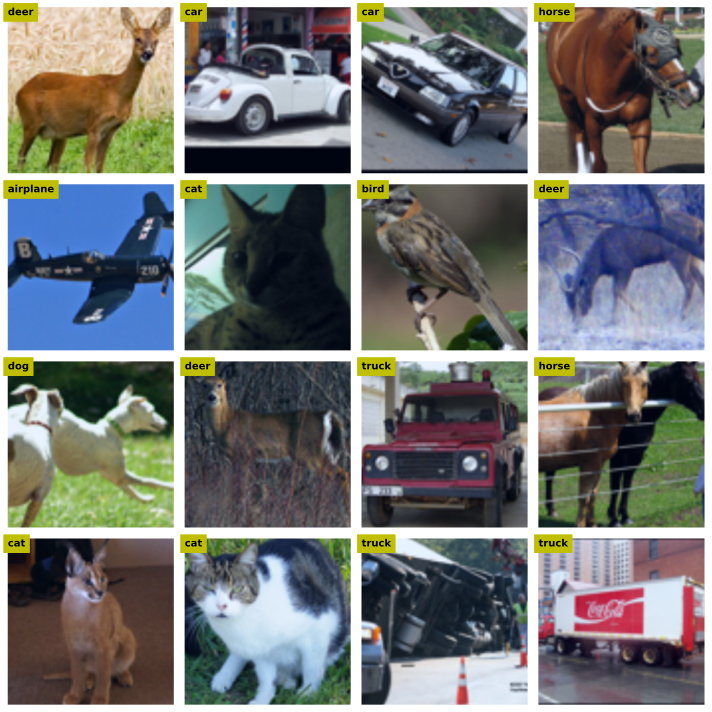

In [9]:
fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic-np.min(pic) # undo normalization
    pic = pic/np.max(pic)

    label = train_data.classes[y[i]]

    ax.imshow(pic)
    ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
def train_step(model, data_loader, loss_fn, optimizer, device):

    model.train()

    train_loss, train_acc = 0, 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return train_loss / len(data_loader), train_acc / len(data_loader)


def test_step(model, data_loader, loss_fn, device):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return test_loss / len(data_loader), test_acc / len(data_loader)

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        end_time = timer()

        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"time: {(end_time-start_time):.4f}"
        )

    return results

def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def get_preds_and_trues(model, data_loader, device):

    model.eval()


    y_preds = []
    y_true = []

    with torch.inference_mode():
        for X, y in data_loader:

            X = X.to(device)

            y_pred = model(X)

            y_pred = torch.softmax(y_pred, dim=1).argmax(dim=1)
            y_preds.append(y_pred.cpu())
            y_true.append(y.cpu())

    return torch.cat(y_preds), torch.cat(y_true)

# Import and inspect the resnet model

In [ ]:
weights = torchvision.models.ResNet18_Weights.DEFAULT
resnet = torchvision.models.resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(resnet.to(device),(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [ ]:
# Freeze all layers (final layer changed later)
for p in resnet.parameters():
    p.requires_grad = False


In [ ]:
# change the final layer
resnet.fc = nn.Linear(512, 10)

In [ ]:
resnet.to(device);

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet.parameters(), lr=0.001)

In [ ]:
results = train(
    model=resnet,
    train_data_loader=train_dataloader,
    test_data_loader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7922 | train_acc: 79.6775 | test_loss: 0.3126 | test_acc: 92.8500 | time: 19.7379
Epoch: 2 | train_loss: 0.3063 | train_acc: 91.7596 | test_loss: 0.2334 | test_acc: 93.5375 | time: 19.0852
Epoch: 3 | train_loss: 0.2363 | train_acc: 92.8145 | test_loss: 0.2097 | test_acc: 93.5125 | time: 19.3000
Epoch: 4 | train_loss: 0.2069 | train_acc: 93.9291 | test_loss: 0.1936 | test_acc: 94.1125 | time: 19.0369
Epoch: 5 | train_loss: 0.1885 | train_acc: 94.4068 | test_loss: 0.2004 | test_acc: 93.5625 | time: 19.1542
Epoch: 6 | train_loss: 0.1770 | train_acc: 94.8248 | test_loss: 0.1751 | test_acc: 94.3125 | time: 19.1578
Epoch: 7 | train_loss: 0.1553 | train_acc: 95.2229 | test_loss: 0.2035 | test_acc: 93.3500 | time: 19.0897
Epoch: 8 | train_loss: 0.1499 | train_acc: 95.3822 | test_loss: 0.1756 | test_acc: 94.1125 | time: 19.0658
Epoch: 9 | train_loss: 0.1409 | train_acc: 95.5812 | test_loss: 0.1765 | test_acc: 94.2625 | time: 19.1839
Epoch: 10 | train_loss: 0.1342 | trai

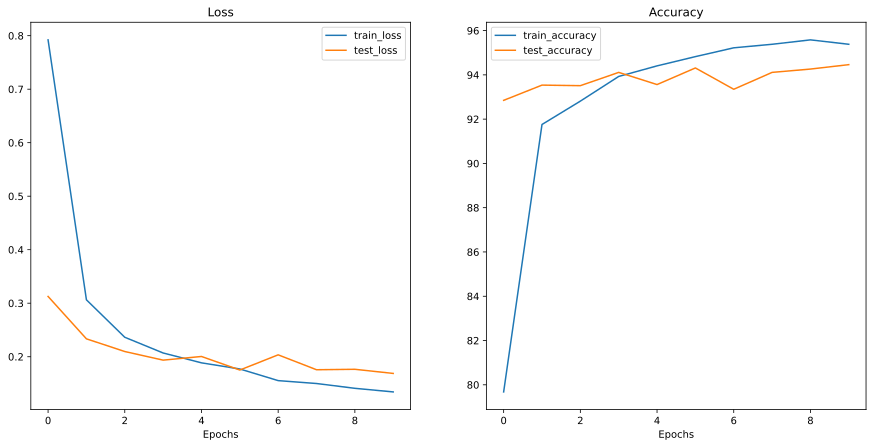

In [ ]:
plot_loss_curves(results)

In [ ]:
y_preds, y_true = get_preds_and_trues(resnet, test_dataloader, device)

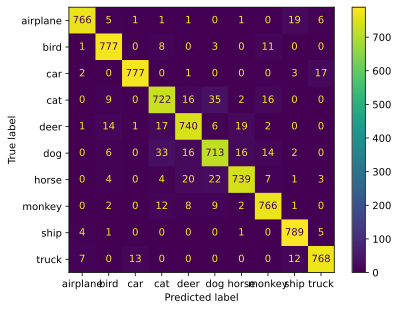

In [ ]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=train_data.classes)
disp.plot()

## Fine Tuning

In [ ]:
weights = torchvision.models.ResNet18_Weights.DEFAULT
resnet_2 = torchvision.models.resnet18(weights=weights)

In [ ]:
# change the final layer
resnet_2.fc = nn.Linear(512,10)

In [ ]:
resnet_2.to(device);

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet_2.parameters(), lr=0.00005)

In [ ]:
results = train(
    model=resnet_2,
    train_data_loader=train_dataloader,
    test_data_loader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=4,
    device=device,
)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6329 | train_acc: 81.9268 | test_loss: 0.2196 | test_acc: 94.0375 | time: 27.9208
Epoch: 2 | train_loss: 0.1361 | train_acc: 97.1537 | test_loss: 0.1671 | test_acc: 94.4250 | time: 27.0678
Epoch: 3 | train_loss: 0.0525 | train_acc: 99.3033 | test_loss: 0.1587 | test_acc: 95.0875 | time: 27.0841
Epoch: 4 | train_loss: 0.0253 | train_acc: 99.8010 | test_loss: 0.1493 | test_acc: 95.1125 | time: 27.1143


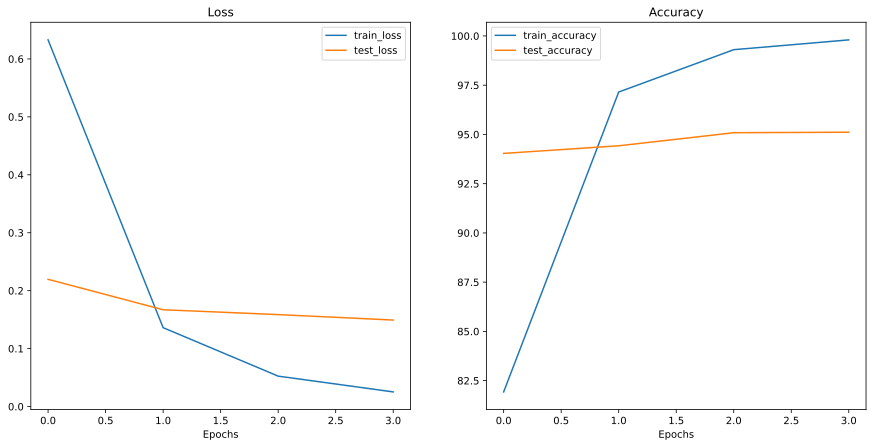

In [ ]:
plot_loss_curves(results)

In [ ]:
y_preds, y_true = get_preds_and_trues(resnet_2, test_dataloader, device)

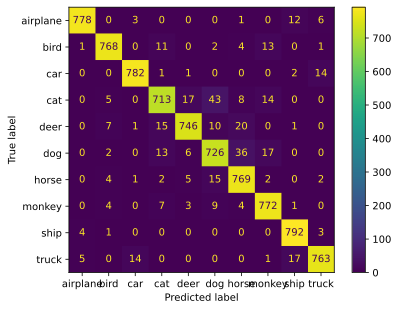

In [ ]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=train_data.classes)
disp.plot()

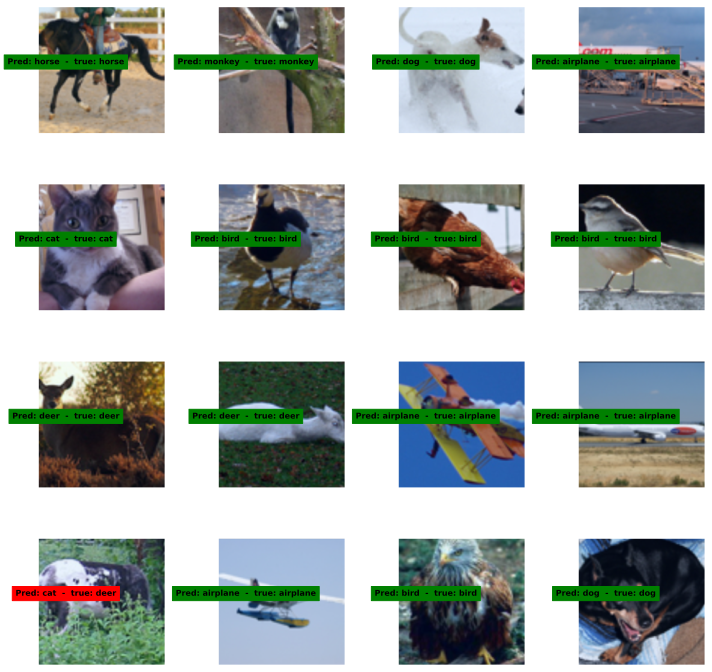

In [ ]:
# inspect a few random images

X,y = next(iter(test_dataloader))
X = X.to(device)
y = y.to(device)
resnet_2.eval()
with torch.inference_mode():
    predictions = torch.argmax(resnet_2(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 96x96x3)
    pic = X.data[i].cpu().numpy().transpose((1,2,0))
    pic = pic-np.min(pic) # undo normalization
    pic = pic/np.max(pic)

    # show the image
    ax.imshow(pic)


    # label and true class
    label = train_data.classes[predictions[i]]
    truec = train_data.classes[y[i]]
    title = f'Pred: {label}  -  true: {truec}'

    # set the title with color-coded accuracy
    titlecolor = 'g' if truec==label else 'r'
    ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()